In [1]:
import os
import sys
import vote
import time
import pickle
import random
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import plotly.io as pio
from maverick import Maverick
import plotly.graph_objs as go
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)
warnings.filterwarnings("ignore")
from IPython.display import clear_output
from sklearn.metrics import accuracy_score, matthews_corrcoef, f1_score
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, confusion_matrix, roc_auc_score

2025-01-19 23:19:37.755205: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-19 23:19:37.823124: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-19 23:19:37.824964: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-19 23:19:38.833003: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%load_ext memory_profiler

In [3]:
repo_dir = "cic-iov-2024"
if not os.path.exists("../cic-iov-2024"):
    !git clone https://github.com/val-co/cic-iov-2024.git

DATASET_DIRECTORY = '/home/ubuntu/Maverick/' + repo_dir + '/'

In [4]:
# Dictionary to store dataframes
dataframes = {}

# Loop through all files in the directory
for filename in os.listdir(DATASET_DIRECTORY):
    
    # Check if the file is a CSV
    if filename.endswith('.csv'):
        
        # Generate the variable name from the filename (remove '.csv')
        var_name = os.path.splitext(filename)[0]
        
        # Read the CSV file into a DataFrame
        file_path = os.path.join(DATASET_DIRECTORY, filename)
        dataframes[var_name] = pd.read_csv(file_path)
        
        # Drop the last 2 columns
        dataframes[var_name] = dataframes[var_name].iloc[:, :-2]
        
        # Identify the third last column
        third_last_col = dataframes[var_name].columns[-1]
        
        # Replace values in the third last column
        dataframes[var_name][third_last_col] = dataframes[var_name][third_last_col].replace({'ATTACK': 1, 'BENIGN': 0})

# Optionally, print the variables to verify
for var_name, df in dataframes.items():
    print(f"DataFrame '{var_name}'")

DataFrame 'decimal_spoofing-GAS'
DataFrame 'decimal_spoofing-SPEED'
DataFrame 'decimal_spoofing-RPM'
DataFrame 'decimal_spoofing-STEERING_WHEEL'
DataFrame 'decimal_DoS'
DataFrame 'decimal_benign'


In [5]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Combine all DataFrames into a single X (features) and y (labels)
X = pd.concat([df.iloc[:, :-1] for df in dataframes.values()], axis=0, ignore_index=True)
y = pd.concat([df.iloc[:, -1] for df in dataframes.values()], axis=0, ignore_index=True)

def create_5folds(X, y, random_state=42):
    X_folds, y_folds = {}, {}
    X_train, X_surrogate, X_test = {}, {}, {}
    y_train, y_surrogate, y_test = {}, {}, {}
    
    # First split: 80/20
    X_80, X_folds[0], y_80, y_folds[0] = train_test_split(X, y, 
        test_size=0.2, random_state=random_state, shuffle=True,)
    
    # Split 80 into 40/40
    X_40_1, X_40_2, y_40_1, y_40_2 = train_test_split(X_80, y_80, 
        test_size=0.5, random_state=random_state, shuffle=True,)
    
    # Split first 40 into 20/20
    X_folds[1], X_folds[2], y_folds[1], y_folds[2] = train_test_split(X_40_1, y_40_1, 
        test_size=0.5, random_state=random_state, shuffle=True,)
    
    # Split second 40 into 20/20
    X_folds[3], X_folds[4], y_folds[3], y_folds[4] = train_test_split(X_40_2, y_40_2, 
        test_size=0.5, random_state=random_state, shuffle=True,)
    
    fold_indices = {0, 1, 2, 3, 4}
    for fold in range(5):
        test_fold = fold
        surrogate_fold = (fold + 1) % 5
        train_fold = fold_indices - {surrogate_fold, test_fold}
        X_test[fold], y_test[fold] = X_folds[test_fold], y_folds[test_fold]
        X_surrogate[fold], y_surrogate[fold] = X_folds[surrogate_fold], y_folds[surrogate_fold]
        X_train[fold], y_train[fold] = pd.concat([X_folds[i] for i in train_fold]), pd.concat([y_folds[i] for i in train_fold])

    del X_folds, y_folds
    return X_train, y_train, X_surrogate, y_surrogate, X_test, y_test

In [6]:
X_train, y_train, X_surrogate, y_surrogate, X_test, y_test = create_5folds(X, y)

##### Then we train a Random Forest or XGBoost Classifier

In [7]:
import joblib
from pathlib import Path
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

Path("models").mkdir(exist_ok=True)

if not Path("models/rf_model_fold_0.joblib").exists():
    model0 = RandomForestClassifier(n_estimators=254, max_depth=10, random_state=42)
    model0.fit(X_train[0], y_train[0])
    print("Model-0 Trained")
    joblib.dump(model0, "models/rf_model_fold_0.joblib")

if not Path("models/rf_model_fold_1.joblib").exists():
    model1 = RandomForestClassifier(n_estimators=254, max_depth=10, random_state=42)
    model1.fit(X_train[1], y_train[1])
    print("Model-1 Trained")
    joblib.dump(model1, "models/rf_model_fold_1.joblib")

if not Path("models/rf_model_fold_2.joblib").exists():
    model2 = RandomForestClassifier(n_estimators=254, max_depth=10, random_state=42)
    model2.fit(X_train[2], y_train[2])
    print("Model-2 Trained")
    joblib.dump(model2, "models/rf_model_fold_2.joblib")

if not Path("models/rf_model_fold_3.joblib").exists():
    model3 = RandomForestClassifier(n_estimators=254, max_depth=10, random_state=42)
    model3.fit(X_train[3], y_train[3])
    print("Model-3 Trained")
    joblib.dump(model3, "models/rf_model_fold_3.joblib")

if not Path("models/rf_model_fold_4.joblib").exists():
    model4 = RandomForestClassifier(n_estimators=254, max_depth=10, random_state=42)
    model4.fit(X_train[4], y_train[4])
    print("Model-4 Trained")
    joblib.dump(model4, "models/rf_model_fold_4.joblib")

model0 = joblib.load("models/rf_model_fold_0.joblib")
model1 = joblib.load("models/rf_model_fold_1.joblib")
model2 = joblib.load("models/rf_model_fold_2.joblib")
model3 = joblib.load("models/rf_model_fold_3.joblib")
model4 = joblib.load("models/rf_model_fold_4.joblib")
print("Loaded Models")

Loaded Models


Ensuring that the maximum number of leaves per tree is less than 255 (needed by OC-Score)

In [8]:
if hasattr(model0, 'estimators_'):  # Confirm that the model has trained estimators
    max_leaves = max(estimator.get_n_leaves() for estimator in model0.estimators_)
    print(f"Maximum number of leaves (Model-0): {max_leaves}")

if hasattr(model1, 'estimators_'):  # Confirm that the model has trained estimators
    max_leaves = max(estimator.get_n_leaves() for estimator in model1.estimators_)
    print(f"Maximum number of leaves (Model-1): {max_leaves}")

if hasattr(model2, 'estimators_'):  # Confirm that the model has trained estimators
    max_leaves = max(estimator.get_n_leaves() for estimator in model2.estimators_)
    print(f"Maximum number of leaves (Model-2): {max_leaves}")

if hasattr(model3, 'estimators_'):  # Confirm that the model has trained estimators
    max_leaves = max(estimator.get_n_leaves() for estimator in model3.estimators_)
    print(f"Maximum number of leaves (Model-3): {max_leaves}")

if hasattr(model4, 'estimators_'):  # Confirm that the model has trained estimators
    max_leaves = max(estimator.get_n_leaves() for estimator in model4.estimators_)
    print(f"Maximum number of leaves (Model-4): {max_leaves}")

Maximum number of leaves (Model-0): 30
Maximum number of leaves (Model-1): 30
Maximum number of leaves (Model-2): 30
Maximum number of leaves (Model-3): 30
Maximum number of leaves (Model-4): 30


In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd

# Create lists to store metrics for each model
metrics = []

# Calculate metrics for each model
for i in range(5):
    model = eval(f"model{i}")
    ypred = model.predict(X_test[i])
    
    # Calculate accuracy
    acc = accuracy_score(ypred, y_test[i])
    
    # Calculate confusion matrix metrics
    tn, fp, fn, tp = confusion_matrix(ypred, y_test[i]).ravel()
    tpr = tp / (tp + fn)  # True positive rate
    tnr = tn / (tn + fp)  # True negative rate
    fpr = fp / (fp + tn)  # False positive rate
    fnr = fn / (fn + tp)  # False negative rate
    
    # Store metrics
    metrics.append({
        'Model': f'Model-{i}',
        'Accuracy': f'{acc:.3f}',
        'TPR': f'{tpr:.3f}',
        'TNR': f'{tnr:.3f}',
        'FPR': f'{fpr:.3f}',
        'FNR': f'{fnr:.3f}'
    })

# Create DataFrame and display
df_metrics = pd.DataFrame(metrics)
print("\nModel Performance Metrics:")
print("=" * 80)
print(df_metrics.to_string(index=False))
print("=" * 80)


Model Performance Metrics:
  Model Accuracy   TPR   TNR   FPR   FNR
Model-0    1.000 1.000 1.000 0.000 0.000
Model-1    1.000 1.000 1.000 0.000 0.000
Model-2    1.000 1.000 1.000 0.000 0.000
Model-3    1.000 1.000 1.000 0.000 0.000
Model-4    1.000 1.000 1.000 0.000 0.000


##### Then we train a surrogate model

In [10]:
import joblib
from pathlib import Path
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

Path("surrogates").mkdir(exist_ok=True)

if not Path("surrogates/rf_surrogate_fold_0.joblib").exists():
    surrogate0 = RandomForestClassifier(n_estimators=254, max_depth=10, random_state=42)
    surrogate0.fit(X_surrogate[0], y_surrogate[0])
    print("Surrogate-0 Trained")
    joblib.dump(surrogate0, "surrogates/rf_surrogate_fold_0.joblib")

if not Path("surrogates/rf_surrogate_fold_1.joblib").exists():
    surrogate1 = RandomForestClassifier(n_estimators=254, max_depth=10, random_state=42)
    surrogate1.fit(X_surrogate[1], y_surrogate[1])
    print("Surrogate-1 Trained")
    joblib.dump(surrogate1, "surrogates/rf_surrogate_fold_1.joblib")

if not Path("surrogates/rf_surrogate_fold_2.joblib").exists():
    surrogate2 = RandomForestClassifier(n_estimators=254, max_depth=10, random_state=42)
    surrogate2.fit(X_surrogate[2], y_surrogate[2])
    print("Surrogate-2 Trained")
    joblib.dump(surrogate2, "surrogates/rf_surrogate_fold_2.joblib")

if not Path("surrogates/rf_surrogate_fold_3.joblib").exists():
    surrogate3 = RandomForestClassifier(n_estimators=254, max_depth=10, random_state=42)
    surrogate3.fit(X_surrogate[3], y_surrogate[3])
    print("Surrogate-3 Trained")
    joblib.dump(surrogate3, "surrogates/rf_surrogate_fold_3.joblib")

if not Path("surrogates/rf_surrogate_fold_4.joblib").exists():
    surrogate4 = RandomForestClassifier(n_estimators=254, max_depth=10, random_state=42)
    surrogate4.fit(X_surrogate[4], y_surrogate[4])
    print("Surrogate-4 Trained")
    joblib.dump(surrogate4, "surrogates/rf_surrogate_fold_4.joblib")

surrogate0 = joblib.load("surrogates/rf_surrogate_fold_0.joblib")
surrogate1 = joblib.load("surrogates/rf_surrogate_fold_1.joblib")
surrogate2 = joblib.load("surrogates/rf_surrogate_fold_2.joblib")
surrogate3 = joblib.load("surrogates/rf_surrogate_fold_3.joblib")
surrogate4 = joblib.load("surrogates/rf_surrogate_fold_4.joblib")
print("Loaded Surrogates")

Loaded Surrogates


In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd

# Create lists to store metrics for each model
metrics = []

# Calculate metrics for each model
for i in range(5):
    model = eval(f"surrogate{i}")
    ypred = model.predict(X_test[i])
    
    # Calculate accuracy
    acc = accuracy_score(ypred, y_test[i])
    
    # Calculate confusion matrix metrics
    tn, fp, fn, tp = confusion_matrix(ypred, y_test[i]).ravel()
    tpr = tp / (tp + fn)  # True positive rate
    tnr = tn / (tn + fp)  # True negative rate
    fpr = fp / (fp + tn)  # False positive rate
    fnr = fn / (fn + tp)  # False negative rate
    
    # Store metrics
    metrics.append({
        'Surrogate': f'Surrogate-{i}',
        'Accuracy': f'{acc:.3f}',
        'TPR': f'{tpr:.3f}',
        'TNR': f'{tnr:.3f}',
        'FPR': f'{fpr:.3f}',
        'FNR': f'{fnr:.3f}'
    })

# Create DataFrame and display
df_metrics = pd.DataFrame(metrics)
print("Surrogate Performance Metrics:")
print("=" * 80)
print(df_metrics.to_string(index=False))
print("=" * 80)

Surrogate Performance Metrics:
  Surrogate Accuracy   TPR   TNR   FPR   FNR
Surrogate-0    1.000 1.000 1.000 0.000 0.000
Surrogate-1    1.000 1.000 1.000 0.000 0.000
Surrogate-2    1.000 1.000 1.000 0.000 0.000
Surrogate-3    1.000 1.000 1.000 0.000 0.000
Surrogate-4    1.000 1.000 1.000 0.000 0.000


##### Now, we generate adversarial examples for the 'decimal_spoofing-GAS' scenario

In [50]:
folder_path = "adversarials/spoof_gas"
os.makedirs(folder_path, exist_ok=True)

A_spoof_gas_path = os.path.join(folder_path, "A_spoof_gas.pkl")
L_spoof_gas_path = os.path.join(folder_path, "L_spoof_gas.pkl")

A_spoof_gas_exists = os.path.exists(A_spoof_gas_path)
L_spoof_gas_exists = os.path.exists(L_spoof_gas_path)

if A_spoof_gas_exists and L_spoof_gas_exists:
    with open(A_spoof_gas_path, "rb") as a_file:
        A_spoof_gas = pickle.load(a_file)
    with open(L_spoof_gas_path, "rb") as l_file:
        L_spoof_gas = pickle.load(l_file)
    print("Loaded Adversarial Examples")
else:
    A_spoof_gas, L_spoof_gas = {}, {}
    for fold in range(5):
        random.seed(42)
        df_dcg = dataframes['decimal_spoofing-GAS'].drop_duplicates().merge(pd.concat([X_test[fold], y_test[fold]], axis=1))
        datas = df_dcg.iloc[:, :-1]
        labels = df_dcg.iloc[:, -1]
        model = eval(f"surrogate{fold}")
        ids = eval(f"model{fold}")
        A_spoof_gas[fold], L_spoof_gas[fold] = [], []
        def label_checker(expected, mapping):
            return vote.mapping_check_argmax(mapping, expected)
        print('Finding Adversarial Examples for fold ', str(fold))
        e = vote.Ensemble.from_sklearn(model)
        deltas = [0, 15, 15, 15, 15, 15, 15, 15, 15]
        for i in tqdm(range(len(labels))):
            def check_robustness(m):
                o = vote.mapping_check_argmax(m, labels.iloc[i])
                if o == vote.FAIL:
                    center = [m.inputs[dim].lower + (m.inputs[dim].upper - m.inputs[dim].lower) / random.randrange(2, 101, 2) for dim in range(m.nb_inputs)]
                    if(ids.predict([center]) != labels.iloc[i]):
                        A_spoof_gas[fold].append(center)
                        L_spoof_gas[fold].append(labels.iloc[i])
                return o
            domain = [(max(x - delta, 0), min(2047, x + delta)) if idx == 0 else (max(x - delta, 0), min(255, x + delta)) for idx, (x, delta) in enumerate(zip(datas.iloc[i].values, deltas))]
            e.absref(check_robustness, domain)
        print("Adversarial Examples Found: ", len(A_spoof_gas[fold]), "\n")

        with open(A_spoof_gas_path, "wb") as a_file:
            pickle.dump(A_spoof_gas, a_file)

        with open(L_spoof_gas_path, "wb") as l_file:
            pickle.dump(L_spoof_gas, l_file)
    

Finding Adversarial Examples for fold  0


100%|██████████| 1950/1950 [00:03<00:00, 640.40it/s]


Adversarial Examples Found:  0 

Finding Adversarial Examples for fold  1


100%|██████████| 1980/1980 [00:22<00:00, 88.07it/s] 


Adversarial Examples Found:  1018 

Finding Adversarial Examples for fold  2


100%|██████████| 2028/2028 [00:49<00:00, 40.90it/s]


Adversarial Examples Found:  989 

Finding Adversarial Examples for fold  3


100%|██████████| 2034/2034 [00:38<00:00, 52.39it/s]


Adversarial Examples Found:  2034 

Finding Adversarial Examples for fold  4


100%|██████████| 1999/1999 [00:23<00:00, 85.24it/s] 

Adversarial Examples Found:  984 



##### Now, we generate adversarial examples for the 'decimal_spoofing-SPEED' scenario

In [51]:
folder_path = "adversarials/spoof_speed"
os.makedirs(folder_path, exist_ok=True)

A_spoof_speed_path = os.path.join(folder_path, "A_spoof_speed.pkl")
L_spoof_speed_path = os.path.join(folder_path, "L_spoof_speed.pkl")

A_spoof_speed_exists = os.path.exists(A_spoof_speed_path)
L_spoof_speed_exists = os.path.exists(L_spoof_speed_path)

if A_spoof_speed_exists and L_spoof_speed_exists:
    with open(A_spoof_speed_path, "rb") as a_file:
        A_speed = pickle.load(a_file)
    with open(L_spoof_gas_path, "rb") as l_file:
        L_speed = pickle.load(l_file)
    print("Loaded Adversarial Examples")
else:
    A_spoof_speed, L_spoof_speed = {}, {}
    for fold in range(5):
        random.seed(42)
        df_dcs = dataframes['decimal_spoofing-SPEED'].drop_duplicates().merge(pd.concat([X_test[fold], y_test[fold]], axis=1))
        datas = df_dcs.iloc[:, :-1]
        labels = df_dcs.iloc[:, -1]
        model = eval(f"surrogate{fold}")
        ids = eval(f"model{fold}")
        
        def label_checker(expected, mapping):
            return vote.mapping_check_argmax(mapping, expected)
        
        print('Finding Adversarial Examples for fold ', str(fold))
        e = vote.Ensemble.from_sklearn(model)
        
        A_spoof_speed[fold], L_spoof_speed[fold] = [], []
        
        deltas = [0, 15, 15, 15, 15, 15, 15, 15, 15]
        
        for i in tqdm(range(len(labels))):
            def check_robustness(m):
                o = vote.mapping_check_argmax(m, labels.iloc[i])
                if o == vote.FAIL:
                    center = [m.inputs[dim].lower + (m.inputs[dim].upper - m.inputs[dim].lower) / random.randrange(2, 101, 2) for dim in range(m.nb_inputs)]
                    if(ids.predict([center]) != labels.iloc[i]):
                        A_spoof_speed[fold].append(center)
                        L_spoof_speed[fold].append(labels.iloc[i])
                return o
            
            domain = [(max(x - delta, 0), min(2047, x + delta)) if idx == 0 else (max(x - delta, 0), min(255, x + delta)) for idx, (x, delta) in enumerate(zip(datas.iloc[i].values, deltas))]
            
            e.absref(check_robustness, domain)
        print("Adversarial Examples Found: ", len(A_spoof_speed[fold]), "\n")
        
        with open(A_spoof_speed_path, "wb") as a_file:
            pickle.dump(A_spoof_speed, a_file)

        with open(L_spoof_speed_path, "wb") as l_file:
            pickle.dump(L_spoof_speed, l_file)

Finding Adversarial Examples for fold  0


100%|██████████| 4937/4937 [01:54<00:00, 43.21it/s]


Adversarial Examples Found:  3924 

Finding Adversarial Examples for fold  1


100%|██████████| 5027/5027 [01:53<00:00, 44.30it/s]


Adversarial Examples Found:  2007 

Finding Adversarial Examples for fold  2


100%|██████████| 5131/5131 [01:49<00:00, 46.86it/s]


Adversarial Examples Found:  3117 

Finding Adversarial Examples for fold  3


100%|██████████| 4939/4939 [01:24<00:00, 58.76it/s] 


Adversarial Examples Found:  2009 

Finding Adversarial Examples for fold  4


100%|██████████| 4917/4917 [01:51<00:00, 44.29it/s]


Adversarial Examples Found:  2959 



##### Now, we generate adversarial examples for the 'decimal_spoofing-RPM' scenario

In [52]:
folder_path = "adversarials/spoof_rpm"
os.makedirs(folder_path, exist_ok=True)

A_spoof_rpm_path = os.path.join(folder_path, "A_spoof_rpm.pkl")
L_spoof_rpm_path = os.path.join(folder_path, "L_spoof_rpm.pkl")

A_spoof_rpm_exists = os.path.exists(A_spoof_rpm_path)
L_spoof_rpm_exists = os.path.exists(L_spoof_rpm_path)

if A_spoof_rpm_exists and L_spoof_rpm_exists:
    with open(A_spoof_rpm_path, "rb") as a_file:
        A_rpm = pickle.load(a_file)
    with open(L_spoof_rpm_path, "rb") as l_file:
        L_rpm = pickle.load(l_file)
    print("Loaded Adversarial Examples")
else:
    A_spoof_rpm, L_spoof_rpm = {}, {}
    for fold in range(5):
        random.seed(42)
        df_dcr = dataframes['decimal_spoofing-RPM'].drop_duplicates().merge(pd.concat([X_test[fold], y_test[fold]], axis=1))
        datas = df_dcr.iloc[:, :-1]
        labels = df_dcr.iloc[:, -1]
        model = eval(f"surrogate{fold}")
        ids = eval(f"model{fold}")

        def label_checker(expected, mapping):
            return vote.mapping_check_argmax(mapping, expected)
        
        print('Finding Adversarial Examples for fold ', str(fold))
        e = vote.Ensemble.from_sklearn(model)
        
        A_spoof_rpm[fold], L_spoof_rpm[fold] = [], []
        
        deltas = [0, 0, 0, 15, 15, 0, 14, 0, 14]
        
        for i in tqdm(range(len(labels))):
            def check_robustness(m):
                o = vote.mapping_check_argmax(m, labels.iloc[i])
                if o == vote.FAIL:
                    center = [m.inputs[dim].lower + (m.inputs[dim].upper - m.inputs[dim].lower) / random.randrange(2, 101, 2) for dim in range(m.nb_inputs)]
                    if(ids.predict([center]) != labels.iloc[i]):
                        A_spoof_rpm[fold].append(center)
                        L_spoof_rpm[fold].append(labels.iloc[i])
                return o
            
            domain = [(max(x - delta, 0), min(2047, x + delta)) if idx == 0 else (max(x - delta, 0), min(255, x + delta)) for idx, (x, delta) in enumerate(zip(datas.iloc[i].values, deltas))]
            
            e.absref(check_robustness, domain)
        print("Adversarial Examples Found: ", len(A_spoof_rpm[fold]), "\n")
        
        with open(A_spoof_rpm_path, "wb") as a_file:
            pickle.dump(A_spoof_rpm, a_file)

        with open(L_spoof_rpm_path, "wb") as l_file:
            pickle.dump(L_spoof_rpm, l_file)

Finding Adversarial Examples for fold  0


  2%|▏         | 174/10795 [00:00<00:06, 1736.91it/s]

100%|██████████| 10795/10795 [00:42<00:00, 251.88it/s] 


Adversarial Examples Found:  1937 

Finding Adversarial Examples for fold  1


100%|██████████| 11049/11049 [00:04<00:00, 2328.82it/s]


Adversarial Examples Found:  1 

Finding Adversarial Examples for fold  2


100%|██████████| 10885/10885 [00:45<00:00, 237.60it/s] 


Adversarial Examples Found:  2008 

Finding Adversarial Examples for fold  3


100%|██████████| 11085/11085 [00:40<00:00, 272.93it/s] 


Adversarial Examples Found:  2041 

Finding Adversarial Examples for fold  4


100%|██████████| 11086/11086 [00:47<00:00, 234.02it/s] 

Adversarial Examples Found:  2016 



##### Now, we generate adversarial examples for the 'decimal_spoofing-STEERING_WHEEL' scenario

In [53]:
folder_path = "adversarials/spoof_steering_wheel"
os.makedirs(folder_path, exist_ok=True)

A_spoof_steering_wheel_path = os.path.join(folder_path, "A_spoof_steering_wheel.pkl")
L_spoof_steering_wheel_path = os.path.join(folder_path, "L_spoof_steering_wheel.pkl")

A_spoof_steering_wheel_exists = os.path.exists(A_spoof_steering_wheel_path)
L_spoof_steering_wheel_exists = os.path.exists(L_spoof_steering_wheel_path)

if A_spoof_steering_wheel_exists and L_spoof_steering_wheel_exists:
    with open(A_spoof_steering_wheel_path, "rb") as a_file:
        A_steering_wheel = pickle.load(a_file)
    with open(L_spoof_steering_wheel_path, "rb") as l_file:
        L_steering_wheel = pickle.load(l_file)
    print("Loaded Adversarial Examples")
else:
    A_spoof_steering_wheel, L_spoof_steering_wheel = {}, {}
    for fold in range(5):
        random.seed(42)
        df_dcsw = dataframes['decimal_spoofing-STEERING_WHEEL'].drop_duplicates().merge(pd.concat([X_test[fold], y_test[fold]], axis=1))
        datas = df_dcsw.iloc[:, :-1]
        labels = df_dcsw.iloc[:, -1]
        model = eval(f"surrogate{fold}")
        ids = eval(f"model{fold}")
        
        def label_checker(expected, mapping):
            return vote.mapping_check_argmax(mapping, expected)
        
        print('Finding Adversarial Examples for fold ', str(fold))
        e = vote.Ensemble.from_sklearn(model)
        
        deltas = [0, 17, 17, 17, 17, 17, 17, 17, 17]
        
        A_spoof_steering_wheel[fold], L_spoof_steering_wheel[fold] = [], []
        
        for i in tqdm(range(len(labels))):
            def check_robustness(m):
                o = vote.mapping_check_argmax(m, labels.iloc[i])
                if o == vote.FAIL:
                    center = [m.inputs[dim].lower + (m.inputs[dim].upper - m.inputs[dim].lower) / random.randrange(2, 101, 2) for dim in range(m.nb_inputs)]
                    if(ids.predict([center]) != labels.iloc[i]):
                        A_spoof_steering_wheel[fold].append(center) 
                        L_spoof_steering_wheel[fold].append(labels.iloc[i]) 
                return o
            
            domain = [(max(x - delta, 0), min(2047, x + delta)) if idx == 0 else (max(x - delta, 0), min(255, x + delta)) for idx, (x, delta) in enumerate(zip(datas.iloc[i].values, deltas))]
            
            e.absref(check_robustness, domain)
        print("Adversarial Examples Found: ", len(A_spoof_steering_wheel[fold]), "\n")
        
        with open(A_spoof_steering_wheel_path, "wb") as a_file:
            pickle.dump(A_spoof_steering_wheel, a_file)

        with open(L_spoof_steering_wheel_path, "wb") as l_file:
            pickle.dump(L_spoof_steering_wheel, l_file)

Finding Adversarial Examples for fold  0


100%|██████████| 3906/3906 [01:23<00:00, 46.83it/s]


Adversarial Examples Found:  0 

Finding Adversarial Examples for fold  1


100%|██████████| 4050/4050 [01:26<00:00, 46.57it/s]


Adversarial Examples Found:  0 

Finding Adversarial Examples for fold  2


100%|██████████| 3960/3960 [01:57<00:00, 33.64it/s]


Adversarial Examples Found:  0 

Finding Adversarial Examples for fold  3


100%|██████████| 4054/4054 [02:10<00:00, 31.01it/s]


Adversarial Examples Found:  0 

Finding Adversarial Examples for fold  4


100%|██████████| 4007/4007 [01:39<00:00, 40.18it/s]

Adversarial Examples Found:  1973 



##### Now, we generate adversarial examples for the 'decimal_DoS' scenario

In [54]:
folder_path = "adversarials/dos"
os.makedirs(folder_path, exist_ok=True)

A_dos_path = os.path.join(folder_path, "A_dos.pkl")
L_dos_path = os.path.join(folder_path, "L_dos.pkl")

A_dos_exists = os.path.exists(A_dos_path)
L_dos_exists = os.path.exists(L_dos_path)

if A_dos_exists and L_dos_exists:
    with open(A_dos_path, "rb") as a_file:
        A_dos = pickle.load(a_file)
    with open(L_dos_path, "rb") as l_file:
        L_dos = pickle.load(l_file)
    print("Loaded Adversarial Examples")
else:
    A_dos, L_dos = {}, {}
    for fold in range(5):
        random.seed(42)
        df_dd = dataframes['decimal_DoS'].drop_duplicates().merge(pd.concat([X_test[0], y_test[0]], axis=1))
        datas = df_dd.iloc[:, :-1]
        labels = df_dd.iloc[:, -1]
        model = eval(f"surrogate{fold}")
        ids = eval(f"model{fold}")
        
        def label_checker(expected, mapping):
            return vote.mapping_check_argmax(mapping, expected)
        
        print('Finding Adversarial Examples for fold ', str(fold))
        e = vote.Ensemble.from_sklearn(model)
        
        deltas = [7, 0, 15, 15, 15, 15, 15, 15, 15]
        
        A_dos[fold], L_dos[fold] = [], []
        
        for i in tqdm(range(len(labels))):
            def check_robustness(m):
                o = vote.mapping_check_argmax(m, labels.iloc[i])
                if o == vote.FAIL:
                    center = [m.inputs[dim].lower + (m.inputs[dim].upper - m.inputs[dim].lower) / random.randrange(2, 101, 2) for dim in range(m.nb_inputs)]
                    if(ids.predict([center]) != labels.iloc[i]):
                        A_dos[fold].append(center)
                        L_dos[fold].append(labels.iloc[i])
                return o
            
            domain = [(max(x - delta, 0), min(2047, x + delta)) if idx == 0 else (max(x - delta, 0), min(255, x + delta)) for idx, (x, delta) in enumerate(zip(datas.iloc[i].values, deltas))]
            
            e.absref(check_robustness, domain)
        print("Adversarial Examples Found: ", len(A_dos[fold]), "\n")
        
        with open(A_dos_path, "wb") as a_file:
            pickle.dump(A_dos, a_file)

        with open(L_dos_path, "wb") as l_file:
            pickle.dump(L_dos, l_file)

Finding Adversarial Examples for fold  0


100%|██████████| 14999/14999 [05:48<00:00, 43.02it/s]


Adversarial Examples Found:  65 

Finding Adversarial Examples for fold  1


100%|██████████| 14999/14999 [05:01<00:00, 49.81it/s]


Adversarial Examples Found:  29 

Finding Adversarial Examples for fold  2


100%|██████████| 14999/14999 [05:28<00:00, 45.67it/s]


Adversarial Examples Found:  39 

Finding Adversarial Examples for fold  3


100%|██████████| 14999/14999 [05:35<00:00, 44.76it/s]


Adversarial Examples Found:  10687 

Finding Adversarial Examples for fold  4


100%|██████████| 14999/14999 [05:54<00:00, 42.28it/s]

Adversarial Examples Found:  10971 



##### Then we combine all these adversarial datasets

In [68]:
adversarial_examples = {}
true_labels = {}
for fold in range(5):
    ids = eval(f"model{fold}")
    ae = A_spoof_gas[fold] + A_spoof_speed[fold] + A_spoof_rpm[fold] + A_spoof_steering_wheel[fold] + A_dos[fold]
    adversarial_examples[fold] = np.asarray(ae)
    tl  = L_spoof_gas[fold] + L_spoof_speed[fold] + L_spoof_rpm[fold] + L_spoof_steering_wheel[fold] + L_dos[fold]
    true_labels[fold] = np.asarray(tl)
    y_pred = ids.predict(adversarial_examples[fold])
    print("Accuracy on the Adversarial Set, Fold ", str(fold), ": ", round(accuracy_score(y_pred, true_labels[fold]), 2))

Accuracy on the Adversarial Set, Fold  0 :  0.0
Accuracy on the Adversarial Set, Fold  1 :  0.0
Accuracy on the Adversarial Set, Fold  2 :  0.0
Accuracy on the Adversarial Set, Fold  3 :  0.0
Accuracy on the Adversarial Set, Fold  4 :  0.0


In [76]:
sum(len(adversarial_examples[fold]) for fold in range(5))

50808

##### Then we select random samples from the test set

In [79]:
test_set, test_lab = {}, {}
test_lab_sym = {}

for fold in range(5):
    random.seed(42)
    num_samples = len(adversarial_examples[fold])
    selected_indices = random.sample(range(len(X_test[fold])), num_samples)
    X_selected = X_test[fold].iloc[selected_indices].values
    y_selected = y_test[fold].iloc[selected_indices].values
    test_set[fold] = np.concatenate((X_selected, adversarial_examples[fold]))
    test_lab[fold] = np.concatenate((y_selected, true_labels[fold]))
    test_lab_sym[fold] = np.concatenate((np.zeros(len(y_selected), dtype=bool), np.ones(len(true_labels[fold]), dtype=bool)))
    print("Evaluation Samples, Fold ", str(fold), ":", len(test_set[fold]))

Evaluation Samples, Fold  0 : 11852
Evaluation Samples, Fold  1 : 6110
Evaluation Samples, Fold  2 : 12306
Evaluation Samples, Fold  3 : 33542
Evaluation Samples, Fold  4 : 37806


In [80]:
sum(len(test_set[fold]) for fold in range(5))

101616

##### Then we try with OC-Score. Remember, the number of trees is set to 254 so that we can use the uint8 version of OC-Score which is highly optimized.

In [ ]:
if not os.path.exists("ocscore"):
    !git clone https://github.com/laudv/ocscore.git
%cd ocscore
!pip install cython numpy dtai-veritas
!python3 setup.py build_ext --inplace
!git pull

%cd ..
sys.path.append('/home/ubuntu/Maverick/K-Fold Standard-CAN/ocscore')

/home/ubuntu/Maverick/K-Fold Standard-CAN/ocscore
running build_ext
Already up to date.
/home/ubuntu/Maverick/K-Fold Standard-CAN


In [82]:
import ocscore
# Get all attributes of the module
module_attributes = dir(ocscore)

# Filter out functions from the attributes
functions = [attr for attr in module_attributes if callable(getattr(ocscore, attr))]

# Print the list of functions
print("List of functions:")
for function in functions:
    print(function)

List of functions:
__pyx_unpickle_Enum
_prep_input
_validate_input
mapids
ocscores
ocscores_topk


In [84]:
idref, idquery = {}, {}

for fold in range(5):
    ids = eval(f"model{fold}")
    ytrain_pred = ids.predict(X_train[fold]) 
    xref_mask = ytrain_pred == y_train[fold]
    xref = X_train[fold][xref_mask]
    dtype = np.uint8
    idref[fold] = ids.apply(xref).astype(dtype)
    idquery[fold] = ids.apply(test_set[fold]).astype(dtype)
    print("Generated Reference and Query Set for Fold ", str(fold))

Generated Reference and Query Set for Fold  0
Generated Reference and Query Set for Fold  1
Generated Reference and Query Set for Fold  2
Generated Reference and Query Set for Fold  3
Generated Reference and Query Set for Fold  4


In [86]:
S = {}
times = {}

Path("ocscore_experiments").mkdir(exist_ok=True)
S_path = Path(f"ocscore_experiments/S.pkl")
T_path = Path(f"ocscore_experiments/times.pkl")

if not (S_path.exists() and T_path.exists()):
    for fold in range(5):
        print("Finding OC-Scores for Fold ", str(fold))
        t1 = time.time()
        S[fold] = ocscore.ocscores(idref[fold], idquery[fold])
        t2 = time.time()
        times[fold] = round(((1000000.0*(t2 - t1))/len(S[fold])), 2)
        print(f"Done, OC-score Average Prediction Time: ", round(((1000000.0*(t2 - t1))/len(S[fold])), 2), "μs", "\n")
    with open(S_path, 'wb') as f:
        pickle.dump(S, f)
    with open(T_path, 'wb') as f:
        pickle.dump(times, f)
else:
    with open(S_path, 'rb') as f:
        S = pickle.load(f)
    with open(T_path, 'rb') as f:
        times = pickle.load(f)
    print("Loaded OC-scores and Times from disk.")      

Finding OC-Scores for Fold  0
Done, OC-score Average Prediction Time:  6279.2 μs 

Finding OC-Scores for Fold  1
Done, OC-score Average Prediction Time:  6110.72 μs 

Finding OC-Scores for Fold  2
Done, OC-score Average Prediction Time:  5928.12 μs 

Finding OC-Scores for Fold  3
Done, OC-score Average Prediction Time:  5801.74 μs 

Finding OC-Scores for Fold  4
Done, OC-score Average Prediction Time:  5747.17 μs 



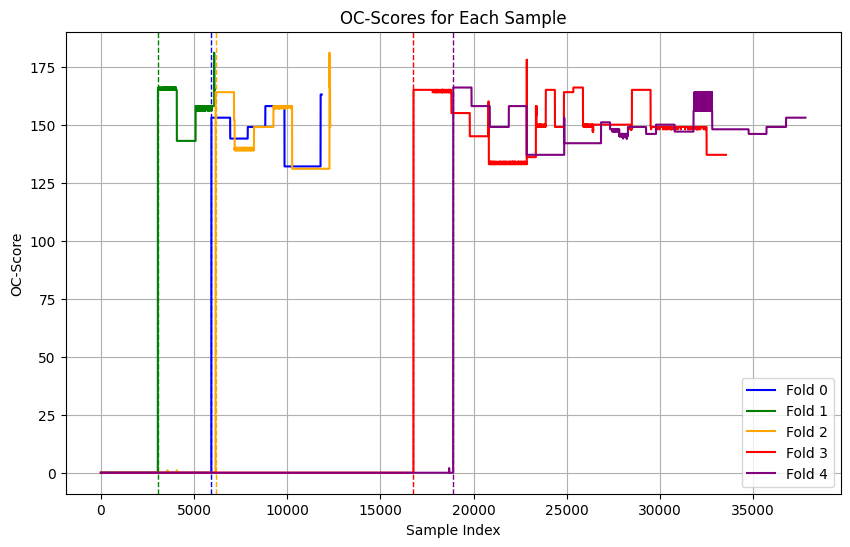

In [87]:
import matplotlib.pyplot as plt
from collections import Counter

colors = ['blue', 'green', 'orange', 'red', 'purple']
plt.figure(figsize=(10, 6))

for fold in range(5):
    plt.plot(S[fold], label=f'Fold {fold}', color=colors[fold], markersize=1)
    plt.axvline(x=Counter(test_lab_sym[fold])[0], color=colors[fold], linestyle='--', linewidth=1)
plt.title('OC-Scores for Each Sample')
plt.xlabel('Sample Index')
plt.ylabel('OC-Score')
plt.legend(title="Folds")
plt.grid(True)
plt.legend()
plt.show()

In [92]:
threshold = 100
results = []

for fold in range(5):
    predictions = []
    ids = eval(f"model{fold}")
    preds = ids.predict(test_set[fold])
    
    for score, pred in zip(S[fold], preds):
        if score <= threshold:
            predictions.append(pred)
        else:
            predictions.append(abs(1-pred))
    
    acc = round(accuracy_score(predictions, test_lab[fold]), 3)
    f1 = round(f1_score(predictions, test_lab[fold]), 3)
    mcc = round(matthews_corrcoef(predictions, test_lab[fold]), 3)
    auc = round(roc_auc_score(predictions, test_lab[fold]), 3)
    tn, fp, fn, tp = confusion_matrix(predictions, test_lab[fold]).ravel()
    tpr = round(tp / (tp + fn), 3)  # True positive rate
    tnr = round(tn / (tn + fp), 3)  # True negative rate
    fpr = round(fp / (fp + tn), 3)  # False positive rate
    fnr = round(fn / (fn + tp), 3)  # False negative rate

    results.append({
        'Fold': fold, 'Accuracy': acc, 'F1-Score': f1, 'MCC': mcc, 'AUC': auc, 'TPR': tpr, 'TNR': tnr, 'FPR': fpr, 'FNR': fnr
    })
df_results = pd.DataFrame(results)
print(df_results)

   Fold  Accuracy  F1-Score  MCC  AUC  TPR  TNR  FPR  FNR
0     0       1.0       1.0  1.0  1.0  1.0  1.0  0.0  0.0
1     1       1.0       1.0  1.0  1.0  1.0  1.0  0.0  0.0
2     2       1.0       1.0  1.0  1.0  1.0  1.0  0.0  0.0
3     3       1.0       1.0  1.0  1.0  1.0  1.0  0.0  0.0
4     4       1.0       1.0  1.0  1.0  1.0  1.0  0.0  0.0


In [93]:
def convert(number, unit='micro'):
    if unit == 'micro':
        result = number * 1e6
    elif unit == 'milli':
        result = number * 1e3
    elif unit == 'nano':
        result = number * 1e9
    else:
        raise ValueError("Invalid unit. Choose from 'micro', 'milli', or 'nano'.")
    return round(result, 3)

##### Then we create Maverick and compare its performance!

In [196]:
mav = {}
experiments_dir = Path("maverick-experiments")
experiments_dir.mkdir(exist_ok=True)

for fold in range(5):
    ids = eval(f"model{fold}")
    save_filename = experiments_dir / f"autoencoder_standard_{fold}.h5"
    mav[fold] = Maverick(ids, X_train[fold], y_train[fold], save_filename=str(save_filename))

Initializing Maverick...
Loading File: maverick-experiments/autoencoder_standard_0.h5
Initialization Complete!
Initializing Maverick...
Loading File: maverick-experiments/autoencoder_standard_1.h5
Initialization Complete!
Initializing Maverick...
Loading File: maverick-experiments/autoencoder_standard_2.h5
Initialization Complete!
Initializing Maverick...
Loading File: maverick-experiments/autoencoder_standard_3.h5
Initialization Complete!
Initializing Maverick...
Loading File: maverick-experiments/autoencoder_standard_4.h5
Initialization Complete!


148/148 [==============================] - 1s 6ms/step


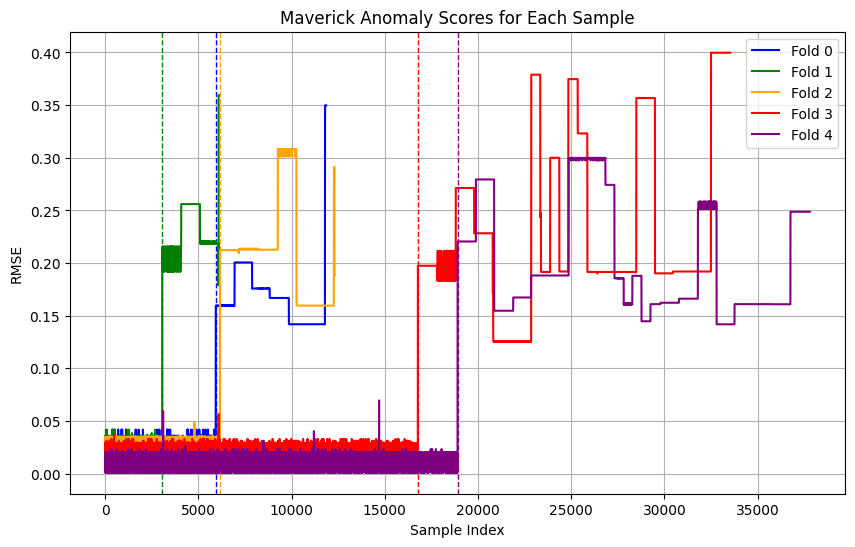

In [197]:
R = {}

for fold in range(5):
    R[fold] = mav[fold].anomaly_scores(test_set[fold])
    
colors = ['blue', 'green', 'orange', 'red', 'purple']
plt.figure(figsize=(10, 6))

for fold in range(5):
    plt.plot(R[fold], label=f'Fold {fold}', color=colors[fold], markersize=1)
    plt.axvline(x=Counter(test_lab_sym[fold])[0], color=colors[fold], linestyle='--', linewidth=1)
plt.title('Maverick Anomaly Scores for Each Sample')
plt.xlabel('Sample Index')
plt.ylabel('RMSE')
plt.legend(title="Folds")
plt.grid(True)
plt.legend()
plt.show()

In [181]:
metrics = []
threshold = 0.1
columns = ["Fold", "Acc.", "F1-Sc.", "MCC", "AUC", "TPR", "TNR", "FPR", "FNR"]

for fold in range(5):
    predictions = []
    ids = eval(f"model{fold}")
    Rf = mav[fold].anomaly_scores(test_set[fold])
    preds = ids.predict(test_set[fold])
    predictions = np.where(Rf <= threshold, preds, np.abs(1 - preds))  
    accuracy = round(accuracy_score(predictions, test_lab[fold]), 3)
    f1 = round(f1_score(predictions, test_lab[fold]), 3)
    mcc = round(matthews_corrcoef(predictions, test_lab[fold]), 3)
    auc = round(roc_auc_score(predictions, test_lab[fold]), 3)
    tn, fp, fn, tp = confusion_matrix(predictions, test_lab[fold]).ravel()
    tpr = round(tp / (tp + fn), 3)  # True positive rate
    tnr = round(tn / (tn + fp), 3)  # True negative rate
    fpr = round(fp / (fp + tn), 3)  # False positive rate
    fnr = round(fn / (fn + tp), 3)  # False negative rate
    metrics.append([fold, accuracy, f1, mcc, auc, tpr, tnr, fpr, fnr])
metrics_df = pd.DataFrame(metrics, columns=columns)
print(metrics_df)

148/148 [==============================] - 1s 6ms/step
   Fold  Acc.  F1-Sc.  MCC  AUC  TPR  TNR  FPR  FNR
0     0   1.0     1.0  1.0  1.0  1.0  1.0  0.0  0.0
1     1   1.0     1.0  1.0  1.0  1.0  1.0  0.0  0.0
2     2   1.0     1.0  1.0  1.0  1.0  1.0  0.0  0.0
3     3   1.0     1.0  1.0  1.0  1.0  1.0  0.0  0.0
4     4   1.0     1.0  1.0  1.0  1.0  1.0  0.0  0.0


In [199]:
raise SystemExit("The bottom timing experiments take too long (30 seconds for Maverick and 40 minutes for OC-Score)")

SystemExit: The bottom timing experiments take too long (30 seconds for Maverick and 40 minutes for OC-Score)

Maverick: Computing min, max, average and standard deviation!

Finding the fold with the largest test set

In [182]:
test_set = [test_set[0], test_set[1], test_set[2], test_set[3], test_set[4]]
index = np.array([len(item) for item in test_set]).argmax()
print("Fold ID:", index)

Fold ID: 4


In [183]:
times = []

for _ in range(10):
    start_time = time.time()
    y_pred = mav[index].predict(test_set[index], threshold=0.10)
    end_time = time.time()
    times.append(convert((end_time - start_time)/len(test_set[index])))
    
# Calculate statistics
min_time = min(times)
max_time = max(times)
avg_time_mav = np.mean(times)
std_dev_time = np.std(times)

# Output the results
print(f"Min time: {round(min_time,3)} μs")
print(f"Max time: {round(max_time,3)} μs")
print(f"Average time: {round(avg_time_mav,3)} μs")
print(f"Standard deviation: {round(std_dev_time,3)} μs")

148/148 [==============================] - 1s 6ms/step
Min time: 70.393 μs
Max time: 79.072 μs
Average time: 74.316 μs
Standard deviation: 2.583 μs


OC-Score: Computing min, max, average and standard deviation!

In [184]:
times = []

for _ in range(10):
    start_time = time.time()
    S = ocscore.ocscores(idref[index], idquery[index])
    print("[+] OC-Score: Predictions Completed")
    end_time = time.time()
    times.append(convert((end_time - start_time)/len(test_set[index])))
    
# Calculate statistics
min_time = min(times)
max_time = max(times)
avg_time_oc = np.mean(times)
std_dev_time = np.std(times)

# Output the results
print(f"Min time: {round(min_time,3)} μs")
print(f"Max time: {round(max_time,3)} μs")
print(f"Average time: {round(avg_time_oc,3)} μs")
print(f"Standard deviation: {round(std_dev_time,3)} μs")

[+] OC-Score: Predictions Completed
[+] OC-Score: Predictions Completed
[+] OC-Score: Predictions Completed
[+] OC-Score: Predictions Completed
[+] OC-Score: Predictions Completed
[+] OC-Score: Predictions Completed
[+] OC-Score: Predictions Completed
[+] OC-Score: Predictions Completed
[+] OC-Score: Predictions Completed
[+] OC-Score: Predictions Completed
Min time: 6084.268 μs
Max time: 6412.639 μs
Average time: 6298.644 μs
Standard deviation: 126.145 μs
